## Libraries

The relevant libraries are imported. These include the numerical computation and plotting libraries.

Warnings that are occasionally generated when codes are ran are suppressed using the _"**ignore**"_ argument

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import os

# Warnings hidden
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

%config InlineBackend.figure_format='svg' # To create high resolution images

## Dataset

Data preprocessing enables us to ensure the data completeness and duplication and have a glimpse of the summary of the data statistics.

In [2]:
df= pd.read_excel("C:/Users/Joshua Nsiah Turkson/Desktop/Joshua/Research/Publications/Machine Learning/IFT/H2 CO2_IFT ML/CH4_N2.xlsx", sheet_name = "All").drop(['CA', 'Carbon dioxide'], axis=1)
df.dropna(inplace=True)
df

,Pressure,Temperature,Salinity,Hydrogen,Nitrogen,Methane,Density difference,IFT
0,3.446429,30.0,0.34188,80,10,5,999.60,71.58
1,6.892857,30.0,0.34188,80,10,5,990.81,69.20
2,10.339286,30.0,0.34188,80,10,5,982.31,67.24
3,13.785714,30.0,0.34188,80,10,5,974.24,66.15
4,17.232143,30.0,0.34188,80,10,5,967.20,65.13
...,...,...,...,...,...,...,...,...
1657,1.033929,40.0,0.34188,40,0,60,1008.90,62.32
1658,1.033929,60.0,0.34188,40,0,60,1000.70,59.89
1659,1.033929,22.0,0.34188,20,0,80,1004.90,63.62
1660,1.033929,40.0,0.34188,20,0,80,1000.50,60.56


In [3]:
df.describe()

,Pressure,Temperature,Salinity,Hydrogen,Nitrogen,Methane,Density difference,IFT
count,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000
mean,11.982871,49.932611,1.767410,49.981949,17.599278,27.454874,995.528213,64.926203
std,5.940264,14.178879,1.119152,20.902276,21.551377,23.289582,46.499266,7.508278
min,1.033929,22.000000,0.341880,20.000000,0.000000,5.000000,835.610000,40.220000
25%,6.892857,40.000000,0.854701,30.000000,5.000000,5.000000,965.550000,59.942500
50%,10.339286,50.000000,1.709402,50.000000,5.000000,20.000000,997.725000,65.300000
75%,17.232143,60.000000,2.564103,70.000000,30.000000,50.000000,1031.500000,70.277500
max,20.678571,70.000000,3.418803,80.000000,70.000000,80.000000,1087.310000,85.920000


In [4]:
# Identify duplicate rows based on all columns
duplicate_rows = df[df.duplicated()]

# Print or store the duplicate rows
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
    # Save duplicate rows to a new CSV file
    duplicate_rows.to_csv('duplicate_rows.csv', index=False)
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [5]:
X= df.drop(['IFT'],axis=1)

In [6]:
y=df['IFT'].astype(float)

In [7]:
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=5,train_size=.7)

In [8]:
# Normalization of input instances
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## Hyperparameter tuning

The RandomSearchCV approach is utilized for hyperparameter optimization to improve model performance. The k-fold cross-validation technique is used in this case.

In [9]:
import time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Parameter grid
param_grid = {
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
}

# Start time
start_time = time.time()

xgb_model = XGBRegressor()

random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid, n_iter=50, cv=5, verbose=1, n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best parameters and corresponding score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Stop the timer
end_time = time.time()

# Elapsed time
elapsed_time = end_time - start_time

print(f"Hyperparameter tuning time: {elapsed_time} seconds")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters:  {'learning_rate': 0.09697027573606312, 'max_depth': 4, 'n_estimators': 618}
Best Score:  0.988658024745216
Hyperparameter tuning time: 18.98165202140808 seconds


## Model training

The optimal hyperparameter values are used in training the model.

In [10]:
lr = random_search.best_params_['learning_rate']
max_depth = random_search.best_params_['max_depth']
n_estimators = random_search.best_params_['n_estimators']

In [11]:
xgbr = XGBRegressor(
    learning_rate=lr,
    max_depth=max_depth,
    n_estimators=n_estimators,
)

xgbr.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09697027573606312,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=618, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
trainscore = xgbr.score(X_train,y_train)
testscore = xgbr.score(X_test,y_test)
print(f'Trainscore: {trainscore}')
print(f'Testscore: {testscore}')

Trainscore: 0.9986274599956857
Testscore: 0.9886122383418584


In [13]:
import joblib

# Model save
joblib.dump(xgbr, 'XGBoost.joblib')

# Load model for predictions
loaded_xgbr_model = joblib.load('XGBoost.joblib')

## Evaluating model performance

Here, various statistical metrics such as mean absolute error, root mean square, and coefficient of determination are used to assess the performance of the constructed model.

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_abs=mean_absolute_error(y_test,loaded_xgbr_model.predict(X_test))
mean_squared=mean_squared_error(y_test,loaded_xgbr_model.predict(X_test))

mean_abs_t=mean_absolute_error(y_train,loaded_xgbr_model.predict(X_train))
mean_squared_t=mean_squared_error(y_train,loaded_xgbr_model.predict(X_train))

In [15]:
mean_abs, mean_squared, mean_abs_t, mean_squared_t

(0.5998381559261097,
 0.6496885220506469,
 0.20904698234945146,
 0.07689358839493406)

## Model predictions for train, test, and entire dataset

### Train data

In [16]:
df1=pd.DataFrame(y_train)
d2=pd.DataFrame(loaded_xgbr_model.predict(X_train), columns=['Train'])
d2.index=df1.index
trainpred=pd.concat([df1, d2], axis=1)
trainpred.to_excel("XGBoost_Train.xlsx")

### Test data

In [17]:
df1=pd.DataFrame(y_test)
d2=pd.DataFrame(loaded_xgbr_model.predict(X_test), columns=['Test'])
d2.index=df1.index
testpred=pd.concat([df1,d2],axis=1)
testpred.to_excel("XGBoost_Test.xlsx")

### All data

In [18]:
df1=pd.DataFrame(y)
d2=pd.DataFrame(loaded_xgbr_model.predict(X), columns=['All'])
d2.index=df1.index
allpred=pd.concat([df1,d2],axis=1)
allpred.to_excel("XGBoost_All.xlsx")

## Permutation importance

Contrary to the correlations matrices, permutation importance considers the non-monotonic effect of the features on the output.

Density difference: 1.0218598389289948
Methane: 0.16742489228668475
Temperature: 0.14994026317900705
Pressure: 0.08729570028443642
Nitrogen: 0.031702874299574565
Salinity: 0.01269496022780641
Hydrogen: 0.0022566438290528698


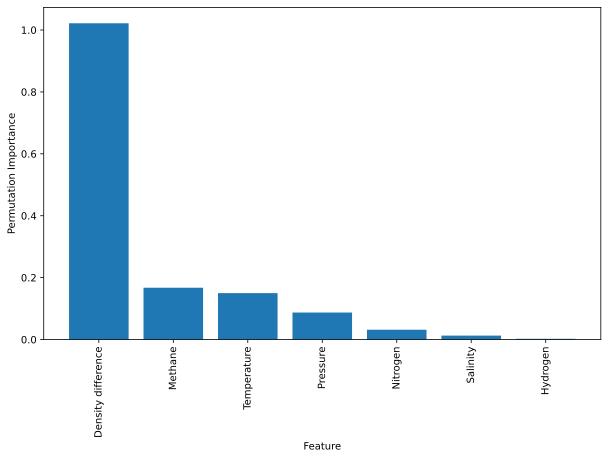

In [19]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Permutation importance
result = permutation_importance(xgbr, X_test, y_test, n_repeats=30, random_state=5, n_jobs=-1)

# Feature importance and scores
feature_importance = result.importances_mean
feature_names = X.columns

# Sorted feature importance
sorted_idx = np.argsort(feature_importance)[::-1]

for i in sorted_idx:
    print(f'{feature_names[i]}: {feature_importance[i]}')

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.show()

## Akaike Information Criterion (AIC)

The AIC provides insights into the goodness of fit of the model and the model complexity. The AIC is given by the mathematical relation:
           
**$$AIC = 2[P_{N} - ln(likelihood)]$$**

where P$_{N}$ is the number of parameters in the model

In [20]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

y_pred = loaded_xgbr_model.predict(X_test)

xgbr_aic = OLS(y_test, add_constant(y_pred)).fit()
print('AIC:', xgbr_aic.aic)

AIC: 1198.222053304984


## Joint plot

In [21]:
data= pd.read_excel("C:/Users/Joshua Nsiah Turkson/Desktop/Joshua/Research/Publications/Machine Learning/IFT/H2 CO2_IFT ML/Notebooks/CH4_N2/XGBoost_Test.xlsx").drop('Unnamed: 0',axis=1)

In [22]:
# A glimpse of the data
data

,IFT,Test
0,75.44,75.212097
1,59.84,59.558792
2,55.30,54.673050
3,66.93,66.723427
4,79.40,81.375710
...,...,...
494,69.25,69.432625
495,68.32,67.342361
496,60.30,59.763378
497,69.04,69.862907


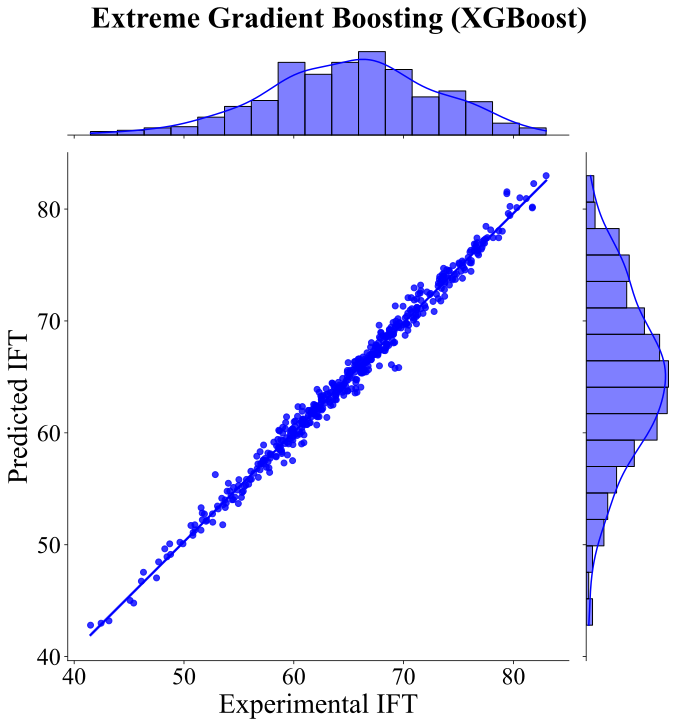

In [27]:
fig= sns.jointplot(x=data['IFT'],y=data['Test'],data=data,kind='reg', color='b', height=10)
plt.gca().set()

fig.fig.suptitle("Extreme Gradient Boosting (XGBoost)", y=1.02, fontsize=30, fontweight='bold')

# Set custom axis labels
fig.set_axis_labels('Experimental IFT', 'Predicted IFT', fontsize=28)

# Saved plot
fig.savefig("XGBoost_Joint plot of Predicted IFT Vs Experimental IFT.png",
            format='png',
            dpi=300,
            bbox_inches='tight')

## Density kernel plot

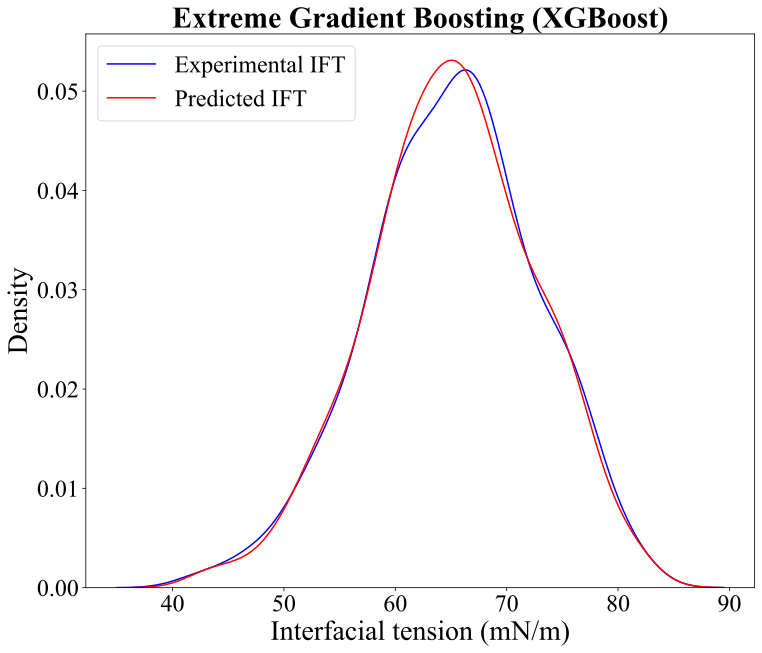

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))

# Distribution for experimental IFT values
ax1 = sns.distplot(y_test, hist=False, color="b", label="Experimental IFT")

# Distribution for predicted IFT values and previous distribution on the same axis
sns.distplot(y_pred, hist=False, color="r", label="Predicted IFT", ax=ax1)

# Legend
ax1.legend()

# # Chart customization
ax.set_title("Extreme Gradient Boosting (XGBoost)", fontsize=30, fontweight="bold")
ax.set_xlabel("Interfacial tension (mN/m)", fontsize=28)
ax.set_ylabel("Density", fontsize = 28)

# Saved plot
plt.savefig("XGBoost_Density_kernel_plot.png",
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Shapley Additive Explanations (SHAP)

The **Shapley Additive Explanations (SHAP)** provides insights into the impact of each of the instance on the final model prediction.

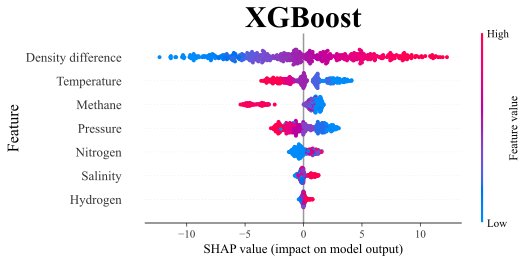

In [25]:
import shap
shap.initjs()

feature_names = X.columns

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 28

# SHAP explainer
explainer = shap.Explainer(xgbr)

shap_values = explainer.shap_values(X_test)
sample_index = 0

plt.figure(figsize=(15, 10))

plt.title("XGBoost", fontsize=30, fontweight='bold')

shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)

plt.ylabel("Feature", fontsize=16)

plt.savefig('XGBoost_SHAP_plot.png',
            format='png', 
            dpi=300, 
            bbox_inches='tight')

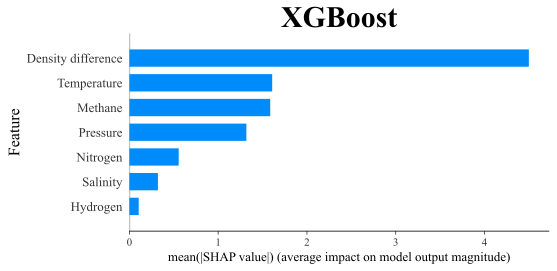

In [26]:
# Mean SHAP value
import shap
shap.initjs()

feature_names = X.columns

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

# SHAP explainer
explainer = shap.Explainer(xgbr)

shap_values = explainer.shap_values(X_test)
sample_index = 0

plt.figure(figsize=(15, 10))

plt.title("XGBoost", fontsize=30, fontweight='bold')

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", auto_size_plot=None, show=False)

plt.ylabel("Feature", fontsize=16)

plt.savefig('XGBoost_Mean_SHAP_plot.png', 
            format='png', 
            dpi=900, 
            bbox_inches='tight')